
*******************************************
+ Name: weixiabing
+ Date: 9/11/22
********************************************



In [1]:
import dask.dataframe as dd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential,load_model
import cupy as cp
from keras.layers import LSTM
from  tensorflow.keras.layers import LSTM,Dense,Activation,Dropout
from  tensorflow.keras.callbacks import History,Callback,EarlyStopping
import os

data=dd.read_csv('D:\library\Github\Innovative-practice\library\csv\第三学期\data_n.csv')
data_cp=cp.array(data)


In [2]:
#多维度标准化
data_normalize=data_cp[:149800,:]
'''scaler=MinMaxScaler(feature_range=(0,1))
data_normalize=scaler.fit_transform(data_cp.get())'''



'scaler=MinMaxScaler(feature_range=(0,1))\ndata_normalize=scaler.fit_transform(data_cp.get())'

In [3]:
'''train_size = int(len(data_normalize) * 0.8)
trainlist = data_normalize[:train_size]
testlist = data_normalize[train_size:]'''
trainlist=data_normalize[:148800]
testlist=data_normalize[148800:149800]
print(trainlist.shape)
print(testlist.shape)

(148800, 5)
(1000, 5)


In [4]:
def create_dataset(dataset, look_back):
#这里的look_back与timestep相同
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back,3])
    return cp.array(dataX),cp.array(dataY)
look_back = 25
trainX,trainY  = create_dataset(trainlist,look_back)
testX,testY = create_dataset(testlist,look_back)
trainX = cp.reshape(trainX, (trainX.shape[0], trainX.shape[1], 5))
testX = cp.reshape(testX, (testX.shape[0], testX.shape[1] ,5 ))
trainY = cp.reshape(trainY, (trainY.shape[0], 1))
testY = cp.reshape(testY, (testY.shape[0], 1))

In [5]:
print(trainX.shape)
print(trainY.shape)

(148774, 25, 5)
(148774, 1)


In [6]:
model = Sequential()
model.add(LSTM(80,input_shape=(trainX.shape[1],trainX.shape[2]),
                   return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(80,return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(trainY.shape[1]))
model.add(Activation("relu"))

model.summary()

cbs = [History(), EarlyStopping(monitor='val_loss',
                                patience=10,
                                min_delta=0.00001,
                                verbose=0)]
model.compile(loss='mse',optimizer='adam')
model.fit(trainX.get(),
        trainY.get(),
        batch_size=64,
        epochs=200,
        validation_split=0.2,
        callbacks=cbs,
        verbose=True)
model.save(os.path.join("DATA","Test_pro" + ".h5"))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 25, 80)            27520     
                                                                 
 dropout (Dropout)           (None, 25, 80)            0         
                                                                 
 lstm_1 (LSTM)               (None, 80)                51520     
                                                                 
 dropout_1 (Dropout)         (None, 80)                0         
                                                                 
 dense (Dense)               (None, 1)                 81        
                                                                 
 activation (Activation)     (None, 1)                 0         
                                                                 
Total params: 79,121
Trainable params: 79,121
Non-traina

In [7]:
model = load_model(os.path.join("DATA","Test_pro" + ".h5"))
trainPredict = model.predict(trainX.get())
testPredict = model.predict(testX[:].get())



31/31 [==============================] - 0s 4ms/step


In [8]:
print(trainPredict.shape)
print(testPredict.shape)

(148774, 1)
(974, 1)


In [9]:
#反归一化
'''scaler= MinMaxScaler(feature_range=(0, 1)).fit(trainPredict)
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(trainY.get())
scaler= MinMaxScaler(feature_range=(0, 1)).fit(testPredict)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY.get())'''

'scaler= MinMaxScaler(feature_range=(0, 1)).fit(trainPredict)\ntrainPredict = scaler.inverse_transform(trainPredict)\ntrainY = scaler.inverse_transform(trainY.get())\nscaler= MinMaxScaler(feature_range=(0, 1)).fit(testPredict)\ntestPredict = scaler.inverse_transform(testPredict)\ntestY = scaler.inverse_transform(testY.get())'

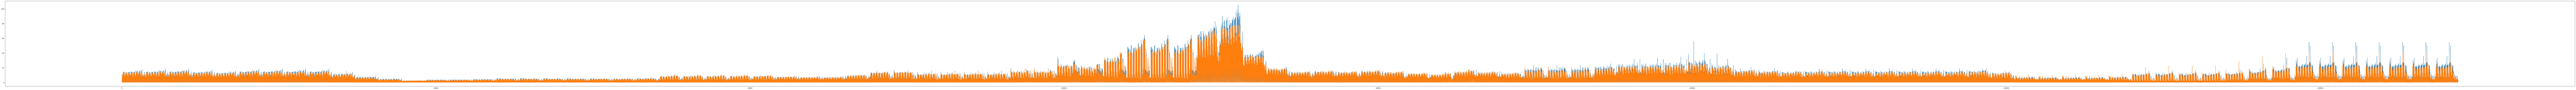

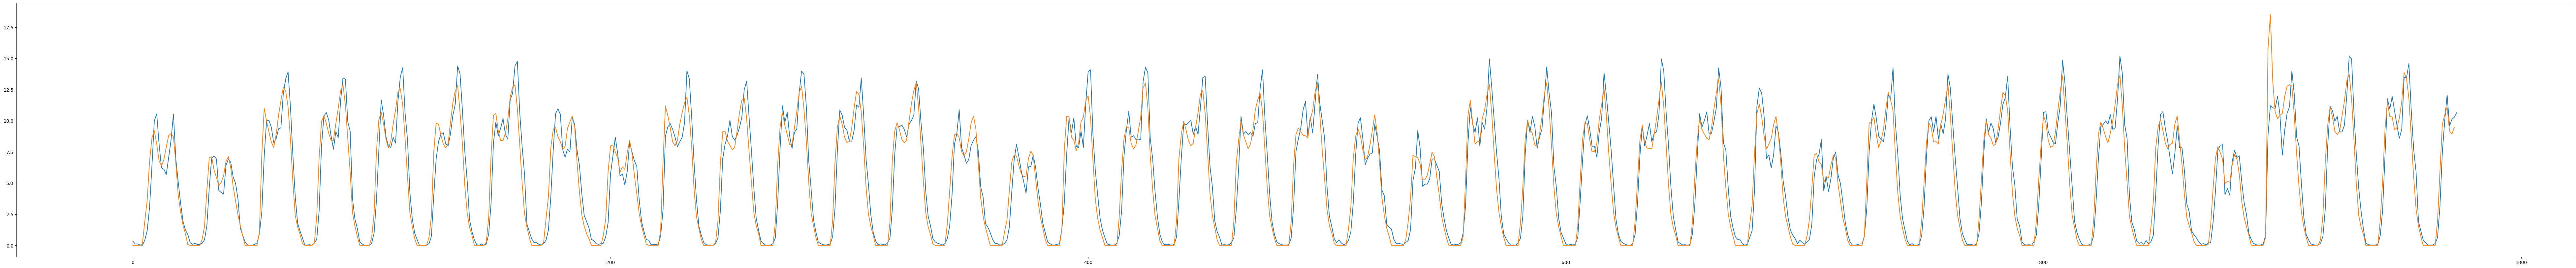

In [9]:
import matplotlib.pyplot as plt
plt.figure( figsize=(300,10) )
plt.plot(trainY.get())
plt.plot(trainPredict[1:])
plt.show()

plt.figure( figsize=(100,10) )
plt.plot(testY[:].get())
plt.plot(testPredict[1:])
plt.show()


In [10]:
from  sklearn import  metrics
import numpy as np

def GetRMSE(y_hat,y_test):
    sum = np.sqrt(metrics.mean_squared_error(y_test, y_hat))
    return  sum

def GetMAE(y_hat,y_test):
    sum = metrics.mean_absolute_error(y_test, y_hat)
    return  sum

def GetMAPE(y_hat,y_test):
    sum = np.mean(np.abs((y_hat - y_test) / y_test)) * 100
    return sum

def GetMAPE_Order(y_hat,y_test):
    #删除test_y 为0元素
    zero_index = np.where(y_test == 0)
    y_hat = np.delete(y_hat,zero_index[0])
    y_test = np.delete(y_test,zero_index[0])
    sum = np.mean(np.abs((y_hat - y_test) / y_test)) * 100
    return sum
#计算R2
def GetR2(y_hat,y_test):
    sum = metrics.r2_score(y_test, y_hat)
    return sum


print("RMSE为", GetRMSE(testY[:].get(), testPredict[:]))
print("MAE为", GetMAE(testY[:].get(), testPredict[:]))
print("MAPE为", GetMAPE_Order(testY[:].get(), testPredict[:]))
print("R2为", GetR2(testY[:].get(), testPredict[:]))


RMSE为 0.9723766567075683
MAE为 0.6503151216732158
MAPE为 21.229796008101147
R2为 0.9507296000063464
